In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import gensim

import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/Documents/Data/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from utils.text import *
from django.db.models import Q, Count, Func, F, Sum, Value, Case, When, IntegerField

### importing data

In [2]:
run_qs = RunStats.objects.filter(psearch__id=83, method="BD", status=3)

pd.DataFrame.from_dict(run_qs.values('run_id', 'coherence', 'exclusivity', 'K', 'alpha',
                                'top_chain_var', 'rng_seed', 'max_iter'))

,K,alpha,coherence,exclusivity,max_iter,rng_seed,run_id,top_chain_var
0,20,0.01,0.400404,0.523049,50,1,2154,0.010
1,45,0.05,0.514492,0.775650,50,1,2137,0.005
2,45,0.01,0.493715,0.846099,50,1,2145,0.010
3,45,0.05,0.370210,0.701541,50,1,2122,0.100
4,45,0.10,0.506084,0.780998,50,1,2121,0.005
5,45,0.10,0.491302,0.871996,50,1,2120,0.010
6,50,0.01,0.496631,0.781455,50,1,2112,0.005
7,45,0.10,0.416262,0.824821,50,1,2119,0.050
8,45,0.01,0.508955,0.742253,50,1,2111,0.005
9,45,0.05,0.480421,0.870453,50,1,2136,0.010


In [3]:
run_id = 2155

save_dir = "./plots/topic_analysis_{}".format(run_id)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

dts = DocTopic.objects.filter(run_id=run_id)
# total score of all DocTopics
print(dts.aggregate(
    n = Sum('score')
))
# total score of DocTopics, sorted by topic
pd.DataFrame.from_dict(list(dts.values('topic__id', 'topic__title').annotate(
    totalscore = Sum('score')
).order_by('-totalscore')))

{'n': 3934749.14997559}


,topic__id,topic__title,totalscore
0,178515,stop words,619234.291928
1,178481,procedural 1,273809.686006
2,178498,economic policy 1,202963.147750
3,178513,procedural 2,142553.991272
4,178495,europe,141410.998528
5,178489,procedural 3,120756.670825
6,178497,general policy statements,116614.982983
7,178478,German-French coal plan,115945.235466
8,178484,budget,110642.907628
9,178472,green opposition,101886.271129


# party proportions aggregate over time

In [4]:
run_id = 2155
topics = Topic.objects.filter(run_id=run_id).order_by('score')

dft_all = pd.DataFrame()

for topic in topics:
    topic_id = topic.id
    topic_label = Topic.objects.get(id=topic_id).title
    t1_party_totals = pm.Utterance.objects.filter(
        doctopic__topic__run_id=run_id, 
        speaker__party__name__isnull=False,
        speaker__party__colour__isnull=False,
        document__parlperiod__n__isnull=False
    ).order_by().values('speaker__party__name').annotate(
        topic_score=Sum(
            Case(
                When(doctopic__topic=topic_id,
                     then=F('doctopic__score')),

                default=0,
                output_field=models.FloatField()
            )),
        total_score=Sum('doctopic__score'),
    ).annotate(topic_proportion=F('topic_score') / F('total_score')).values(
        'topic_score', #doctopicscore
        'total_score',
        'topic_proportion',
        'speaker__party__id',
        'speaker__party__name',
        'speaker__party__colour'
    ).order_by('speaker__party__name')

    dft = pd.DataFrame.from_dict(list(t1_party_totals))
    dft.columns = ['party_colour', 'party_id', 'party_name', 'doctopic_proportion', 'doctopic_score', 'total_doctopic_score']
    dft['topic_id'] = topic_id
    dft['topic_label'] = topic_label

    dft_all = dft_all.append(dft, ignore_index=True)

In [5]:
dft_all

,party_colour,party_id,party_name,doctopic_proportion,doctopic_score,total_doctopic_score,topic_id,topic_label
0,#009EE0,112,afd,0.001511,20.060404,1.327295e+04,178514,pension
1,#000000,107,cducsu,0.005824,9100.742723,1.562719e+06,178514,pension
2,#FFED00,109,fdp,0.003400,1964.789756,5.778155e+05,178514,pension
3,#64A12D,111,gruene,0.002626,781.532489,2.976283e+05,178514,pension
4,#8C3473,108,linke,0.006765,779.362855,1.152122e+05,178514,pension
5,#EB001F,110,spd,0.005490,6461.932176,1.177134e+06,178514,pension
6,#009EE0,112,afd,0.010414,138.219018,1.327295e+04,178508,transport policy
7,#000000,107,cducsu,0.006879,10750.543790,1.562719e+06,178508,transport policy
8,#FFED00,109,fdp,0.006704,3873.400605,5.778155e+05,178508,transport policy
9,#64A12D,111,gruene,0.005133,1527.764058,2.976283e+05,178508,transport policy


In [6]:
dft_score = pd.DataFrame([dft_all['topic_label'], dft_all['party_name'], dft_all['doctopic_score']]).transpose()
dft_score = dft_score.pivot(index='topic_label', columns='party_name', values='doctopic_score')

dft_proportion = pd.DataFrame([dft_all['topic_label'], dft_all['party_name'], dft_all['doctopic_proportion']]).transpose()
dft_proportion = dft_proportion.pivot(index='topic_label', columns='party_name', values='doctopic_proportion')

# manual setting of colour, needs to be adjusted with new party or order change 
party_colour = ["#0088FF", "#000000", "#FFED00", "#64A12D", "#8C3473", "#EB001F"]
sns.set_palette(party_colour)
sns.set_context('talk')

In [8]:
dft_proportion.max()

party_name
afd       0.280329
cducsu    0.157132
fdp       0.179885
gruene    0.158376
linke     0.132584
spd       0.161485
dtype: float64

In [14]:
dft_proportion.sum()

party_name
afd       0.318178
cducsu    0.168627
fdp       0.199847
gruene    0.276274
linke     0.359588
spd       0.159615
dtype: float64

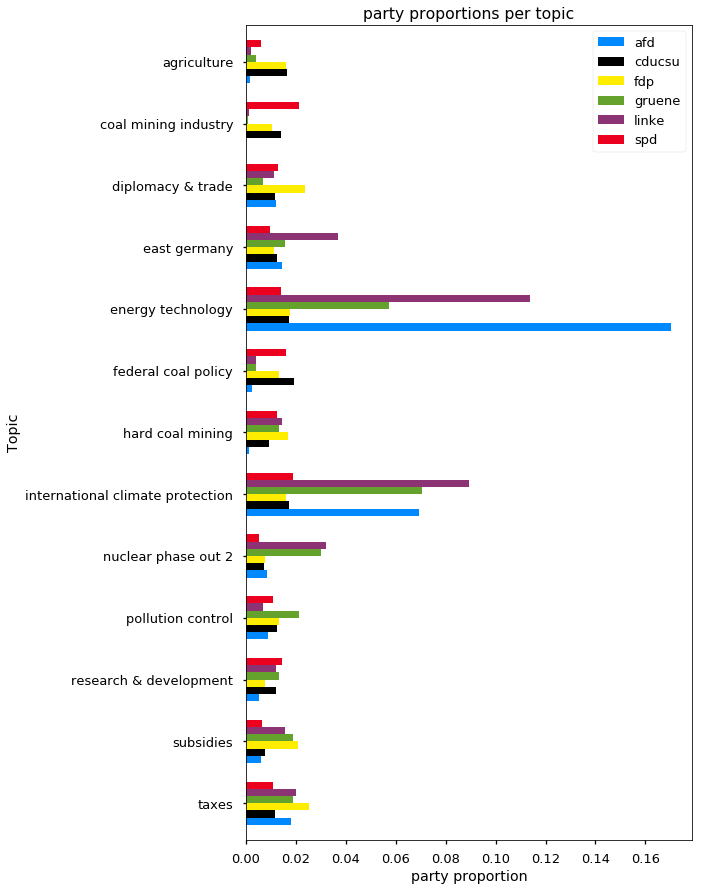

In [13]:
pct = False
stacked = False

topics = list(reversed(["agriculture", "coal mining industry", "diplomacy & trade",
                 "east germany", "energy technology", "federal coal policy",
                 "hard coal mining", "international climate protection", "nuclear phase out 2",
                 "pollution control", "research & development", "subsidies", "taxes"]))

dft_proportion = dft_proportion.loc[topics]

if pct:
    df_plot = dft_proportion.copy()
    for i in df_plot.index:
        df_plot.loc[i] = df_plot.loc[i] / df_plot.loc[i].sum() * 100
    xlabel = '% of party proportion'
    title_str = "Percentage of party proportions per topic"

else:
    xlabel = "party proportion"
    title_str = "party proportions per topic"
    df_plot = dft_proportion

ax = df_plot.plot.barh(stacked=stacked, # title=topic_names[0],
                 figsize=(8,15), width=0.7)

ax.set(xlabel=xlabel, ylabel='Topic', title=title_str)

if pct:
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
else:
    plt.legend(title="")

filename = os.path.join(save_dir, "party_proportions_run_{}_selection".format(run_id))
plt.savefig(filename, dpi=300, bbox_inches="tight")

In [ ]:
# todo: the same for regions, and recycle old plot from non-dynamic topic models (see below)

# see also notebook topic_list_and_analysis_of_parties_and_regions

# this implementation is working but really slow
# because it makes queries to the database for every topic and region separately



coal_regions = cmodels.Region.objects.filter(name__in=["Brandenburg", "North Rhine-Westphalia", "Saxony"])
non_coal_regions = cmodels.Region.objects.filter(name__in=["Baden-Württemberg", "Bavaria", "Berlin", "Bremen", "Hamburg", "Hesse",
                    "Mecklenburg-Vorpommern", "Lower Saxony", "Rheinland-Pfalz",
                    "Saarland", "Saxony-Anhalt", "Schleswig-Holstein", "Thuringia"])

topics = tm.Topic.objects.filter(run_id=run_id).order_by('score')
seat_types = ['direct', 'list', 'sum']
arrays = [range(len(topics)), seat_types]

index = pd.MultiIndex.from_product(arrays, names=['topic #', 'seat_type'])
df_regions = pd.DataFrame(index=index, columns=['coal', 'ncoal', 'topic_id', 'top_words'])

index_to_keyword = {0: 'coal', 1: 'ncoal'}


for i, topic in enumerate(topics):
    print(topic.top_words)

    for j, regions in enumerate([coal_regions, non_coal_regions]):
        print(list(regions))

        region_score_list = pm.Utterance.objects.filter(
                search_matches=s,
                doctopic__topic__run_id=run_id,
                speaker__seat__seat_type=2,
                speaker__seat__list__region__in=regions
            ).distinct().order_by().values('speaker__seat__seat_type').annotate(
                topic_score=models.Sum(
                    models.Case(
                        models.When(doctopic__topic=topic, then=models.F('doctopic__score')),
                        default=0,
                        output_field=models.FloatField()
                    )
                ),
                total_score=models.Sum('doctopic__score'),
            ).annotate(
                topic_proportion=models.F('topic_score') / models.F('total_score')
            )#.values('topic_proportion')

        region_score_direct = pm.Utterance.objects.filter(
                search_matches=s,
                doctopic__topic__run_id=run_id,
                speaker__seat__seat_type=1,
                speaker__seat__constituency__region__in=regions
            ).distinct().order_by().values('speaker__seat__seat_type').annotate(
                topic_score=models.Sum(
                    models.Case(
                        models.When(doctopic__topic=topic, then=models.F('doctopic__score')),
                        default=0,
                        output_field=models.FloatField()
                    )
                ),
                total_score=models.Sum('doctopic__score'),
            ).annotate(
                topic_proportion=models.F('topic_score') / models.F('total_score')
            )#.values('topic_proportion')
        
        for st in seat_types:
            df_regions['top_words'][(i, st)] = topic.top_words
            df_regions['topic_id'][(i, st)] = topic.id

        df_regions[index_to_keyword[j]][(i, 'direct')] = region_score_direct[0]['topic_proportion']
        df_regions[index_to_keyword[j]][(i, 'list')] = region_score_list[0]['topic_proportion']
        total_score = region_score_list[0]['topic_proportion'] + region_score_direct[0]['topic_proportion'] / 2.
        df_regions[index_to_keyword[j]][(i, 'sum')] = total_score
        
        print("score list: {}".format(region_score_list[0]['topic_proportion']))
        print("score direct: {}".format(region_score_direct[0]['topic_proportion']))
        print("sum: {}".format(total_score))
        

# make this more efficient

In [ ]:
# has already been implemented but file was lost somehow

# use dict -> pandas to read out data in bulks, combine them using group_by etc., plot

In [37]:
topic_label = Topic.objects.get(id=topic_id).title
t1_party_totals = pm.Utterance.objects.filter(
    doctopic__topic__run_id=run_id, 
    speaker__party__name__isnull=False,
    speaker__party__colour__isnull=False,
    document__parlperiod__n__isnull=False
).order_by().values('speaker__party__name', 'doctopic__topic__id').annotate(
    topic_score=Sum('doctopic__score'),
).values('doctopic__topic__id',
    'topic_score', #doctopicscore
    'speaker__party__id',
    'speaker__party__name',
    'speaker__party__colour'
).order_by('doctopic__topic__id')
dft = pd.DataFrame.from_dict(list(t1_party_totals))
dft

,doctopic__topic__id,speaker__party__colour,speaker__party__id,speaker__party__name,topic_score
0,177235,#009EE0,112,afd,367.006350
1,177235,#000000,107,cducsu,24614.388185
2,177235,#FFED00,109,fdp,8647.887583
3,177235,#64A12D,111,gruene,11163.708501
4,177235,#8C3473,108,linke,4490.635637
5,177235,#EB001F,110,spd,22774.946918
6,177236,#009EE0,112,afd,79.166798
7,177236,#000000,107,cducsu,24486.069555
8,177236,#FFED00,109,fdp,10841.118289
9,177236,#64A12D,111,gruene,2325.289146


In [38]:
dft.groupby('speaker__party__name').agg({'topic_score': 'sum'})

,topic_score
speaker__party__name,
afd,21185.75
cducsu,1614037.75
fdp,600168.85
gruene,308898.80
linke,113509.70
spd,1216289.55


# compress folder to easily download it

In [ ]:
%%bash
zip -r plots/topic_analysis_2111.zip plots/topic_analysis_2111/